#Ejercicio 3: Filtros sobre imágenes

##1. Introducción
<justify>En este cuaderno, vamos a realizar el aplicado de distintos filtros sobre una imagen dada implementando OpenCL [1]. Los filtros disponibles a aplicar son el negativo (es decir, el complemento de la imagen), escala de grises, sepia, blanco y negro (o binario) según un umbral dado, correciones de contraste, y el filtro Sobel para la detección de bordes.
</justify>

##1.1 Complemento de una imagen
<justify>El complemento o negativo de una imagen es una operación básica [2] (esto es, se aplica pixel por pixel). Siendo L el rango de bits de una imagen (para este trabajo se usa usado el rango de 0 a 255), podemos decir que el complemento está dado por:

<center>$P(x,y) = L - 1 - P(x,y)$</center>

En el caso de tratarse, por ejemplo, de una imagen RGB de 8 bits con sus tres canales de colores, el complemento estará dado por:

<center>$pixel.x = 255 - pixel.x$</center>
<center>$pixel.y = 255 - pixel.y$</center>
<center>$pixel.z = 255 - pixel.z$</center>
</justify>

##1.2 Escala de grises
<justify>La escala de grises de una imagen a color está dada por la siguiente fórmula aplicada a cada uno de los canales propios de la imagen, es decir, se aplica a la *intensidad* de la misma:</justify>

<center>$Intensidad$ $del$ $pixel$ $= 0.2126 * R + 0.7152 * G + 0.0722 * B$     [3]</center>

##1.3 Sepia
<justify>El tono sepia se obtiene aplicando la fórmula descrita a continuación [4]. Sea "pixel" el pixel actual bajo análisis:</justify>

<center>$factorRojo = pixel.x * 0.393 + pixel.y * 0.769 + pixel.z * 0.189$</center>
<center>$factorVerde = pixel.x * 0.349 + pixel.y * 0.686 + pixel.z * 0.168$</center>
<center>$factorAzul = pixel.x * 0.272 + pixel.y * 0.534 + pixel.z * 0.131$</center>

##1.4 Umbral (Thresholding)
<justify>Dado un umbral determinado [2], se pasa a blanco y negro la imagen. Si la intensidad del píxel supera dicho umbral, su intensidad es reemplazada por 255. Caso contrario, es reemplaza por 0.
Decimos que:</justify>

<center>$P(x,y) = 0$  si  $O(x,y) <= umbral$</center>
<center>$P(x,y) = 255$  si  $O(x,y) > umbral$</center>

##1.5 Correcciones de contraste
<justify>Se hacen pequeñas correcciones automáticas al contraste de la imagen. El contraste de la imagen en este ejercicio es calculado de la siguiente manera [6]:</justify>

<center>$contraste_x = (pixel.x - 0.5) * 1.2 + 0.5$</center>
<center>$contraste_y = (pixel.y - 0.5) * 1.2 + 0.5$</center>
<center>$contraste_z = (pixel.z - 0.5) * 1.2 + 0.5$</center>

<justify>Para este ejercicio, se ha dejado fijo el valor de "1.2" que es el correspondiente al contraste. Los valores de "0.5" son para equilibrar los grises a un 50%.</justify>

##1.6 Filtro Sobel
El filtro Sobel es un filtro que es utilizado para la detección de bordes [5, 7]. Consiste en dos máscaras, que son dos matrices de 3x3, una que se aplica sobre el eje x y otra sobre el eje y. La aplicación del filtro está dada por el gradiente de las dos imágenes resultantes al momento de aplicar el filtro tanto sobre el eje x como sobre el eje y.

Siguiendo el teorema de Pitágoras, el gradiente es calculado de la siguiente manera:
<center>$G(x,y) = sqrt(Gx^2 + Gy^2)$</center>

##2. Armado del ambiente
Para el armado del ambiente, es necesario instalar PyOpenCL [1] e importar una imagen a elección a partir de una URL.

###2.1. Instalar PyOpenCL
Procedemos a instalar PyOpenCL mediante la ejecución de la siguiente celda de código.

In [1]:
!pip install pyopencl

##2.2 Importar una imagen
Se le pedirá al usuario que ingrese una dirección URL de una imagen a elección para proceder a aplicarle los filtros necesarios.

In [24]:
#@title Ingrese la dirección URL de una imagen { vertical-output: true }

imagen_url = "https://barcelonaroom.com/wp-content/uploads/2017/04/Sagrada-Familia.png" #@param {type: "string"}


"""
Se dejan algunas imágenes de prueba:
Cosmo: https://upload.wikimedia.org/wikipedia/commons/c/c3/NGC_4414_%28NASA-med%29.jpg
Cuadrada: https://miro.medium.com/max/400/0*C9qMhSqy-GdqP5aM.jpg
Más ancha: https://www.mundoperros.es/wp-content/uploads/2019/03/pitbull-terrier-feliz.jpg
Más larga: https://i.pinimg.com/originals/ab/80/70/ab80707d85d8ef6d5e6ee81da05c30c7.jpg
Súper grande: https://upload.wikimedia.org/wikipedia/commons/3/30/Amazona_aestiva_-upper_body-8a_%281%29.jpg
PNG: https://barcelonaroom.com/wp-content/uploads/2017/04/Sagrada-Familia.png
"""

#verificamos que haya escrito algo valido
if not (type(imagen_url) is str) or (imagen_url == ""):
  raise TypeError("Se tiene que ingresar una dirección URL válida")


#Tomamos la imagen
!wget {imagen_url} -O imagen

--2020-12-02 22:53:43--  https://barcelonaroom.com/wp-content/uploads/2017/04/Sagrada-Familia.png
Resolving barcelonaroom.com (barcelonaroom.com)... 185.119.173.96
Connecting to barcelonaroom.com (barcelonaroom.com)|185.119.173.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 540164 (528K) [image/png]
Saving to: ‘imagen’

imagen              100%[===================>] 527.50K   766KB/s    in 0.7s    

2020-12-02 22:53:45 (766 KB/s) - ‘imagen’ saved [540164/540164]



##3. Desarrollo
Para el desarrollo del programa, en primer lugar, se necesita ejecutar la celda de código que genera el archivo "kernel.cl". Este archivo contiene todas las funciones propias de OpenCL que han sido creadas para el tratamiento de las imágenes. Este archivo ha sido separado para una mejor lectura y comprensión del total del código.

##3.1 Generación del archivo "kernel.cl"
A continuación, generamos el archivo del kernel.

In [25]:
#Generamos el archivo "kernel.cl" que contiene todas las funciones necesarias para el procesamiento de imágenes

codigo = """
const sampler_t sampler = CLK_NORMALIZED_COORDS_FALSE | 
						  CLK_ADDRESS_CLAMP_TO_EDGE | 
						  CLK_FILTER_NEAREST;


__kernel void complemento(__read_only image2d_t original, __write_only image2d_t resultado, __global int *img_ancho, __global int *img_alto)
{
  int ancho = *img_ancho;
  int alto = *img_alto;
  int2 coord = (int2) (get_global_id(0), get_global_id(1));
  
    if (coord.x < ancho && coord.y < alto)  
    {
      uint4 pixel = read_imageui(original, sampler, coord); 
      pixel.x = 255 - pixel.x;
      pixel.y = 255 - pixel.y;
      pixel.z = 255 - pixel.z;

      write_imageui(resultado, coord, pixel);
    }
}

__kernel void escala_grises(__read_only image2d_t original, __write_only image2d_t resultado, __global int *img_ancho, __global int *img_alto)
{
  int ancho = *img_ancho;
  int alto = *img_alto;
  int2 coord = (int2) (get_global_id(0), get_global_id(1));
  
    if (coord.x < ancho && coord.y < alto)  
    { 
      uint4 pixel = read_imageui(original, sampler, coord);

      float color = 0.2126 * pixel.x + 0.7152 * pixel.y + 0.0722 * pixel.z;
      pixel.x = pixel.y = pixel.z = color;

      write_imageui(resultado, coord, pixel);
    }
}

__kernel void umbral(__read_only image2d_t original, __write_only image2d_t resultado, __global int *img_ancho, __global int *img_alto, __global int *img_umbral)
{
  int ancho = *img_ancho;
  int alto = *img_alto;
  int umbral = *img_umbral;
  int2 coord = (int2) (get_global_id(0), get_global_id(1));

    if (coord.x < ancho && coord.y < alto)  
    { 
      uint4 pixel = read_imageui(original, sampler, coord);

      int total = pixel.x + pixel.y + pixel.z;

      if(total > umbral)
        pixel.x = pixel.y = pixel.z = 255;
      else
        pixel.x = pixel.y = pixel.z = 0;


      write_imageui(resultado, coord, pixel);
    }
}


__kernel void contraste(__read_only image2d_t original, __write_only image2d_t resultado, __global int *img_ancho, __global int *img_alto)
{
  int ancho = *img_ancho;
  int alto = *img_alto;
  int2 coord = (int2) (get_global_id(0), get_global_id(1));

  if (coord.x < ancho && coord.y < alto)  
  {
      uint4 pixel = read_imageui(original, sampler, coord);

      pixel.x = (pixel.x - 0.5) * 1.2 + 0.5;
      pixel.y = (pixel.y - 0.5) * 1.2 + 0.5;
      pixel.z = (pixel.z - 0.5) * 1.2 + 0.5;
      
      write_imageui(resultado, coord, pixel);
  }
}


__kernel void sepia(__read_only image2d_t original, __write_only image2d_t resultado, __global int *img_ancho, __global int *img_alto)
{
  int ancho = *img_ancho;
  int alto = *img_alto;
  int2 coord = (int2) (get_global_id(0), get_global_id(1));
  
    if (coord.x < ancho && coord.y < alto)  
    { 
      uint4 pixel = read_imageui(original, sampler, coord);

      float factor_rojo = pixel.x * 0.393 + pixel.y * 0.769 + pixel.z * 0.189;
      
      if(factor_rojo > 255)
        factor_rojo = 255;


      float factor_verde = pixel.x * 0.349 + pixel.y * 0.686 + pixel.z * 0.168;
      if(factor_verde > 255)
        factor_verde = 255;
        

      float factor_azul = pixel.x * 0.272 + pixel.y * 0.534 + pixel.z * 0.131;
      if(factor_azul > 255)
        factor_azul = 255;
        

      pixel.x = factor_rojo;
      pixel.y = factor_verde;
      pixel.z = factor_azul;

      write_imageui(resultado, coord, pixel);
    }
}


__constant int mascaraX[9]={-1,0,1,-2,0,2,-1,0,1};
__constant int mascaraY[9]={-1,-2,-1,0,0,0,1,2,1};

__kernel void sobel(__read_only image2d_t original, __write_only image2d_t resultado, __global int *img_ancho, __global int *img_alto)
{
    int ancho = *img_ancho;
    int alto = *img_alto;
    int2 coord = (int2)(get_global_id(0), get_global_id(1));

    if(coord.x < ancho && coord.y < alto)
    {
      uint4 res_x = (uint4)(0, 0, 0, 255);
      uint4 res_y = (uint4)(0, 0, 0, 255);

      int index = 0;
      for(int x = -1; x<2; x++)
        for(int y = -1; y<2; y++)
        {
          uint4 pixel = read_imageui(original, sampler, (int2)(coord.x + x, coord.y + y));
          res_x += (pixel * mascaraX[index]);
          index++;
        }

      index = 0;
      for(int x = -1; x<2; x++)
        for(int y = -1; y<2; y++)
        {
          uint4 pixel = read_imageui(original, sampler, (int2)(coord.x + x, coord.y + y));
          res_y += (pixel * mascaraY[index]);
          index++;
        }

      uint4 gradiente = (0, 0, 0, 255);
      gradiente.x = (int)sqrt((float)(res_x.x * res_x.x) + (res_y.x * res_y.x));
      gradiente.y = (int)sqrt((float)(res_x.y * res_x.y) + (res_y.y * res_y.y));
      gradiente.z = (int)sqrt((float)(res_x.z * res_x.z) + (res_y.z * res_y.z));

      if(gradiente.x > 255)
        gradiente.x = 255;
      if(gradiente.y > 255)
        gradiente.y = 255;
      if(gradiente.z > 255)
        gradiente.z = 255;


      write_imageui(resultado, coord, gradiente);
    }
}

"""
text_file = open("kernel.cl", "w")
text_file.write(codigo)
text_file.close()


##3.2 Ejecución del programa
Ahora, procedemos a pedirle al usuario los filtros que desea aplicar a la imagen seleccionada.

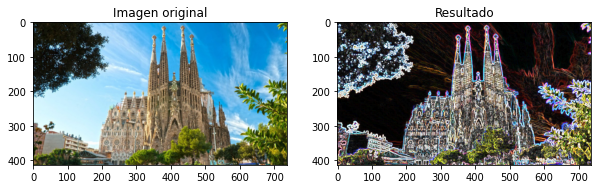

In [27]:
#@title Filtros a aplicar
#@markdown Seleccionar el filtro que se quiere aplicar a la imagen
 
Filtros = "Sobel" #@param ["Complemento", "Escala de Grises", "Sepia", "Contraste", "Sobel"]
#@markdown ---
Umbral = False #@param {type: "boolean"}
Rango = 247 #@param {type:"slider", min:0, max:765, step:1}
#@markdown ---

#---------------------------------------------------------------------------------------

#Importamos los módulos necesarios
import numpy as np
import matplotlib.pyplot as plt
import pyopencl as cl
from PIL import Image
%matplotlib inline


#PASO 1: configurar OpenCL
contexto = cl.create_some_context()
cola = cl.CommandQueue(contexto)


#PASO 2: Tomamos la imagen y la pasamos a formato RGBA para una mejor compatibilidad
try:
  imagen = Image.open('imagen')
  if imagen.mode != "RGBA":
    imagen = imagen.convert("RGBA")
except:
  raise Exception("No se pudo abrir la imagen")

#Tomamos las dimensiones de la imagen
ancho, alto = imagen.size

#PASO 3: Pasamos la imagen a array para una mejor manipulación de la misma
img_array = np.asarray(imagen).astype(np.int32)

#Creamos los buffers para las imagenes
#Empezamos por un formato: RBGA de 8 bits
formato = cl.ImageFormat(cl.channel_order.RGBA, cl.channel_type.UNSIGNED_INT8)
#Creamos los buffers para la imagen original y el resultado
img_original = cl.Image(contexto, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, formato, imagen.size, None, imagen.tobytes())
img_resultado = cl.Image(contexto, cl.mem_flags.WRITE_ONLY, formato, imagen.size)

#Creamos los buffers para las variables que pasaremos como parámetro
ancho_gpu = cl.Buffer(contexto, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=np.int32(ancho))
alto_gpu = cl.Buffer(contexto, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=np.int32(alto))


#PASO 4: Abrimos el archivo "kernel.cl" para poder ejecutarlo
try:
  kernel = open("kernel.cl", "r")
except:
  raise Exception("No se encontró el archivo 'kernel.cl'. Verificar la ejecución de la celda anterior")


programa = cl.Program(contexto, kernel.read()).build()


#Vemos lo que pide el usuario para poder ejecutar
if Filtros is "Complemento":
    evento = programa.complemento(cola, imagen.size, None, img_original, img_resultado, ancho_gpu, alto_gpu)
    
if Filtros == "Escala de Grises":
    evento = programa.escala_grises(cola, imagen.size, None, img_original, img_resultado, ancho_gpu, alto_gpu)
    
if Filtros is "Sepia":
    evento = programa.sepia(cola, imagen.size, None, img_original, img_resultado, ancho_gpu, alto_gpu)
    
if Filtros is "Contraste":
    evento = programa.contraste(cola, imagen.size, None, img_original, img_resultado, ancho_gpu, alto_gpu)
    
if Filtros is "Sobel":
    evento = programa.sobel(cola, imagen.size, None, img_original, img_resultado, ancho_gpu, alto_gpu)
    

if Umbral:
    Filtros = "Umbral-" + str(Rango)
    umbral_num = Rango
    #Creamos el buffer para el parametro que le pasamos del umbral
    umbral_gpu = cl.Buffer(contexto, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=np.int32(umbral_num))
    evento = programa.umbral(cola, imagen.size, None, img_original, img_resultado, ancho_gpu, alto_gpu, umbral_gpu)
     
    

#Copiamos el resultado desde la GPU
resultado = np.empty_like(imagen)
cl.enqueue_copy(cola, resultado, img_resultado, origin=(0,0,0), region=(ancho, alto, 1), wait_for=[evento])

#Limpiamos
img_original.release()
img_resultado.release()
ancho_gpu.release()
alto_gpu.release()
cola.flush()
cola.finish()

#Mostramos las imagenes
f = plt.figure(figsize=(10,15))
f.add_subplot(1,2,1)
plt.imshow(imagen)
plt.title("Imagen original")
f.add_subplot(1, 2, 2)
plt.title("Resultado")
plt.imshow(resultado)


Le damos al usuario la opción de descargar la foto editada en su PC o guardarla en su cuenta de Google Drive.

In [31]:
#@title Guardar imagen
#@markdown Seleccionar el destino de la imagen resultante
 
Destino = "Guardar en Google Drive" #@param ["Descargar imagen", "Guardar en Google Drive"]

#-------------------------------------------------------------------------------------

#Importamos los módulos necesarios
from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


#Como primer paso, generamos el archivo de la imagen
nombre_resultado = "resultado_imagen_" + Filtros + ".png"
Image.fromarray(resultado).save(nombre_resultado)

#Ahora vemos dónde guardar
if Destino == 'Descargar imagen': 
    files.download(nombre_resultado)
    print("Descargando imagen...")

if Destino == 'Guardar en Google Drive':
    #Se realiza la autenticación, cosa que se hace una sola vez por notebook
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    #Ahora subimos el archivo
    uploaded = drive.CreateFile({'Imagen generada con OpenCL': 'resultado_imagen.png'})
    uploaded.SetContentFile(nombre_resultado)
    uploaded.Upload()
    print('El archivo ha sido subido a Google Drive con el ID {}'.format(uploaded.get('id')))


#La borramos del notebook
import os
os.remove(nombre_resultado)

El archivo ha sido subido a Google Drive con el ID 1Ye-4RSxBI-8ABZVc0DYBhomrGoQBijxM


##4. Tabla de pasos
A continuación, realizaremos la tabla de pasos de ejecución del programa.

<center>

Procesador | Función | Detalle
--- | --- | ---
CPU | !pip install pyopencl | Instalación de PyOpenCL en el notebook actual
CPU | @param | Lectura del la dirección URL de la imagen desde el formulario de Colab
CPU | if... raise... | Controla que el parámetro pasado por el usuario sea válido
CPU | wget imagen_url | Lectura de la imagen a procesar desde la dirección URL proporcionada
CPU | text_file = open() | Creación del archivo "kernel.cl" que contiene el código OpenCL
CPU | text_file.write() | Escribe en el archivo "kernel.cl" el código generado en la variable "codigo"
CPU | text_file.close() | Cierra el archivo "kernel.cl"
CPU | @param | Lectura de las opciones de filtros a aplicar seleccionada por el usuario
CPU | import | Importa los módulos necesarios para la ejecución del programa
CPU | matplotlib inline | Macro necesaria para mostrar las imágenes
**GPU** | cl.create_some_context() | Creación de un contexto necesario para OpenCL
**GPU** | cl.CommandQueue() | Creación de la cola de comandos de OpenCL
CPU | Image.open() | Abre el archivo de la imagen
CPU | except: raise Exception | Lanza una excepción en el caso de no poder abrir la imagen
CPU | np.asarray(imagen) | Pasa la imagen a un vector para su mejor manipulación
**GPU** | cl.FormatImage() | Crea el formato que será usado para el tratamiento de las imágenes especificando tipo y canal (RGBA de uint8)
**GPU** | cl.Image() | Se crean los buffers necesarios para trabajar con las imágenes (original y resultado)
**GPU** | cl.Buffer() | Se crean dos buffers para el valor del alto y del ancho de la imagen en cuestión
CPU | kernel = open() | Se abre el archivo "kernel.cl" que contiene el código de GPU
CPU | raise Exception | Se genera una excepción en el caso de falla de apertura del archivo "kernel.cl"
**GPU** | cl.Program() | Se compila el código GPU que se encuentra en el archivo "kernel.cl"
CPU | if Filtro is... | Comprueba cuál es el filtro a aplicar
**GPU** | programa.complemento | Aplica el complemento a la imagen
**GPU** | programa.escala_grises | Aplica la escala de grises a la imagen
**GPU** | programa.sepia | Aplica el filtro de sepia a la imagen
**GPU** | programa.sobel | Aplica el filtro Sobel a la imagen
**GPU** | programa.contraste | Aplica contraste automático a la imagen
**GPU** | umbral_gpu = cl.Buffer() | Crea un buffer para poder pasarle a la GPU el valor del umbral seleccionado
**GPU** | programa.umbral | Aplica el filtro del umbral a la imagen
CPU | resultado = np.empty_like() | Generación del array necesario para el resultado de la imagen
**GPU** | cl.enqueue_copy() | Copia los resultados de la imagen desde la memoria GPU al array recién creado en CPU llamado *resultado*
**GPU** | img_original.release() | Libera los recursos que fueron creados (Imágenes y Buffers) de la GPU
CPU | plt.imshow() | Muestra la imagen original junto a la imagen resultado del filtro aplicado
CPU | @param | Toma el parámetro de selección del destino de guardado de la imagen resultante
CPU | from... import... | Importa los módulos necesarios
CPU | Image.fromarray().save() | Guarda el resultado de la imagen procesada como imagen .npg en el notebook
CPU | if Destino == ... | Chequea el destino de la imagen a guardar
CPU | files.download() | Descarga la imagen en la PC
CPU | print() | Informa por pantalla que se está descargando la imagen
CPU | auth.authenticate_user() ... | Se realiza el proceso de autenticación con Google Drive para el guardado de archivos
CPU | uploaded.Upload() | Se sube el archivo a Google Drive
CPU | print() | Informa que el archivo se ha subido a Google Drive
CPU | import os | Importa el módulo necesario para borrar la imagen
CPU | os.remove() | Borramos el archivo resultante de la imagen del notebook
</center>

##5. Conclusiones
<justify>

La implementación de PyOpenCL ha sido muy beneficiosa en cuanto al manejo de las imágenes, y eso se puede ver claramente al momento de querer acceder a los píxeles a trabajar. Esto también es porque ofrece estructuras de datos propia que facilita el manejo de imágenes y vectores, como por ejemplo, para el acceso a los píxeles se da por un vector de 4 dimensiones (dado por uint4 en este ejercicio).

Por otra parte, la herramienta de Google Colab provee de muchas ventajas: además de ofrecer todo un entorno de ejecución tanto para CPU como para GPU, es muy robusta en cuanto a su uso, permitiendo la importación de diferentes módulos e incluso fragmentos de código. Permite trabajar con archivos como cualquier otro IDE, con la ventaja de no necesitar de recursos de hardware para poder desarrollar ciertos programas.
</justify>


##6. Bibliografía

* [1]: [Documentación de PyOpenCL](https://documen.tician.de/pyopencl/)
* [2]: [Procesamiento Digital de Imágenes - Operaciones Básicas](http://www2.elo.utfsm.cl/~elo328/PDI03_Operadores_Basicos.pdf)
* [3]: [Converting color to grayscale - Wikipedia](https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale)
* [4]: [Imagen a color a Sepia](https://www.geeksforgeeks.org/image-procesing-java-set-6-colored-image-sepia-image-conversion/)
* [5]: [Procesamiento de imágenes - Diferentes aplicaciones](http://bibing.us.es/proyectos/abreproy/12112/fichero/Documento_por_capitulos%252F3_Cap%C3%ADtulo_3.pdf)
* [6]: [Point operations - Contrast](https://pippin.gimp.org/image-processing/chap_point.html)
* [7]: [Procesamiento Digital de Imágenes - Transformaciones de Intensidad y Filtrado Espacial](https://www.fceia.unr.edu.ar/dip/Filtrado_Espacial.pdf)
